In [1]:
# temporary fix to unable to import modules in utils.py
import sys
sys.path.append('/home/amk/projects/pcb_defect_detection/src/with_annotation')

In [12]:
from src.with_annotation.dataset import PCBDataset
from src.with_annotation.model import CustomRCNN
import src.with_annotation.transforms as T
from src.with_annotation.utils import train_one_epoch, evaluate
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import src.with_annotation.utils_ as utils
from PIL import Image

root = '/home/amk/data/DeepPCB/PCBData'

In [3]:
def transforms(train):
    t = []
    t.append(T.PILToTensor())
    if train:
        # during training, flip the training images and
        # ground truth for data augmentation
        t.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(t)

In [4]:
batch_size = 2
target_acc = 0.995
lr = 0.0001
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device used: ' + str(device))
model = CustomRCNN()

model.to(device)

# Specity optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Device used: cuda


/home/amk/anaconda3/envs/pcb_detect/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amk/anaconda3/envs/pcb_detect/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
print(model)

CustomRCNN(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=(0.5,), std=(0.5,))
        Resize(min_size=(640,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps

In [6]:
from torch.utils.data import DataLoader

train_data = PCBDataset(root, 'trainval.txt', transforms=transforms(train=True))
test_data = PCBDataset(root, 'test.txt', transforms=transforms(train=False))

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

In [7]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_dataloader, device=device)

Epoch: [0]  [  0/500]  eta: 0:44:30  lr: 0.000015  loss: 4.8389 (4.8389)  loss_classifier: 2.6369 (2.6369)  loss_box_reg: 0.0245 (0.0245)  loss_objectness: 2.1185 (2.1185)  loss_rpn_box_reg: 0.0591 (0.0591)  time: 5.3418  data: 0.1558  max mem: 1282
Epoch: [0]  [ 10/500]  eta: 0:06:43  lr: 0.000115  loss: 3.9361 (3.9494)  loss_classifier: 2.1637 (1.9809)  loss_box_reg: 0.0200 (0.0207)  loss_objectness: 2.1151 (1.8852)  loss_rpn_box_reg: 0.0634 (0.0627)  time: 0.8243  data: 0.0276  max mem: 1477
Epoch: [0]  [ 20/500]  eta: 0:04:51  lr: 0.000215  loss: 2.0198 (2.5153)  loss_classifier: 0.7370 (1.1993)  loss_box_reg: 0.0222 (0.0358)  loss_objectness: 1.0947 (1.2290)  loss_rpn_box_reg: 0.0471 (0.0513)  time: 0.3713  data: 0.0158  max mem: 1479
Epoch: [0]  [ 30/500]  eta: 0:04:08  lr: 0.000315  loss: 0.6689 (1.9201)  loss_classifier: 0.2340 (0.8847)  loss_box_reg: 0.0563 (0.0467)  loss_objectness: 0.3504 (0.9427)  loss_rpn_box_reg: 0.0309 (0.0460)  time: 0.3647  data: 0.0137  max mem: 1479


In [8]:
model_path = '/home/amk/projects/pcb_defect_detection/weights/23.4.29_rcnn_640x640_10ep.h5'
torch.save(model, model_path)

In [9]:
model_path = '/home/amk/projects/pcb_defect_detection/weights/with_annotation/23.4.29_rcnn_640x640_10ep.h5'
model = torch.load(model_path, map_location=device)

In [61]:
# pick one image from the test set
img, lbls = test_data[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

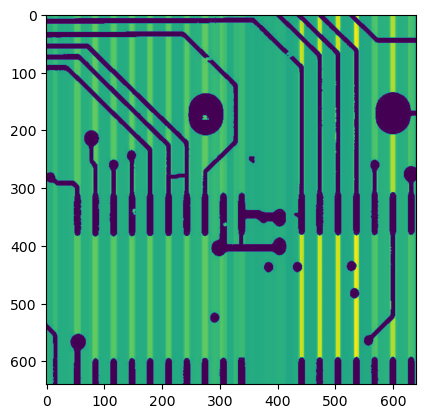

In [63]:
import matplotlib.pyplot as plt
img = img.mul(255).numpy()
img = img[0,:,:]
plt.imshow(img)
plt.show()

In [76]:
import cv2
import matplotlib.pyplot as plt

defect_num = {1: 'open',
              2: 'short',
              3: 'mousebite',
              4: 'spur',
              5: 'copper',
              6: 'pin-hole'}

# pick one image from the test set
img, lbls = test_data[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
img = img.mul(255).numpy()
img = img[0,:,:]
pred = prediction[0]
pred_boxes = pred['boxes'].cpu().numpy()
pred_labels = pred['labels'].cpu().numpy()
pred_scores = pred['scores'].cpu().numpy()
true_boxes = lbls['boxes'].cpu().numpy()
true_labels = lbls['labels'].cpu().numpy()
for i in range(len(boxes)):
    cv2.rectangle(img, (int(boxes[i,0]),int(boxes[i,1])), (int(boxes[i,2]),int(boxes[i,3])), (120, 120, 12), 2)
    cv2.putText(img, defect_num[labels[i]], (int(boxes[i,0]),int(boxes[i,1])), fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(160,160,12),
            thickness=2, lineType=cv2.LINE_AA)
plt.imshow(img)
plt.show()

{'boxes': tensor([[263.,  63., 299.,  90.],
         [201., 266., 251., 294.],
         [296., 350., 322., 376.],
         [419., 333., 448., 361.],
         [341., 236., 370., 267.],
         [260., 165., 291., 192.],
         [139., 327., 166., 356.],
         [324., 367., 350., 410.],
         [403.,  53., 437.,  87.]]),
 'labels': tensor([1, 2, 3, 4, 5, 6, 3, 2, 1]),
 'image_id': tensor(20085291),
 'area': tensor([ 972., 1400.,  676.,  812.,  899.,  837.,  783., 1118., 1156.],
        dtype=torch.float64),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])}